## The Final Preprocessing 

In [1]:
import pandas as pd
import holidays
import numpy as np

## Charging stations split on zip codes (All zip codes from Boulder)

In [2]:
zip_code_df = pd.read_csv('TestDataset/CleanedColoradoData.csv', parse_dates=['Start_DateTime'])

# filter 
start_date = pd.to_datetime('2022-11-30')
end_date = pd.to_datetime('2023-11-30')

df_filtered = zip_code_df[(zip_code_df['Start_DateTime'] >= start_date) & (zip_code_df['Start_DateTime'] <= end_date)]

# Count unique stations per Zip_Postal_Code
stations_per_zip = df_filtered.groupby("Zip_Postal_Code")["Station_Name"].nunique().reset_index()
stations_per_zip.columns = ["Zip_Postal_Code", "Station_Count"]

# Count total sessions per Zip_Postal_Code
sessions_per_zip = df_filtered.groupby("Zip_Postal_Code").size().reset_index(name="Session_Count")

# Merge station counts and session counts
result = pd.merge(stations_per_zip, sessions_per_zip, on="Zip_Postal_Code", how="inner", validate="one_to_one")

# Calculate total number of unique stations
total_stations = df_filtered["Station_Name"].nunique()

# Calculate percentage of total unique stations
result["Station_%"] = (result["Station_Count"] / total_stations) * 100

# Calculate total number of sessions
total_sessions = df_filtered.shape[0]

# Calculate percentage of total sessions per zip code
result["Session_%"] = (result["Session_Count"] / total_sessions) * 100

print(result)

   Zip_Postal_Code  Station_Count  Session_Count  Station_%  Session_%
0            80301             18           5236  39.130435  17.959800
1            80302             21          11196  45.652174  38.402964
2            80303              3           6605   6.521739  22.655553
3            80304              2           2956   4.347826  10.139260
4            80305              2           3161   4.347826  10.842423


In [3]:
# Make a df for each zip code
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    # Split the session into hourly intervals
    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate hourly intervals
        hourly_intervals = pd.date_range(
            start=start.floor('h'), end=end.ceil('h'), freq='h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    # Create a new dataframe from the hourly intervals
    hourly_df = pd.DataFrame(hourly_rows)

    # Aggregate the hourly intervals
    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(
        hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - \
        pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='h')

    # Reindex the hourly data to include all hours in the range
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    # Return the hourly data
    return hourly_df

def add_features(hourly_df):
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day']>= 6) & (hourly_df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  hourly_df['IsHoliday'] = hourly_df.index.map(
      lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(
      2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(
      2 * np.pi * hourly_df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
                     7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  # Lag features
  # 1h
  hourly_df['Energy_Consumption_1h'] = hourly_df['Energy_Consumption'].shift(1)

  # 6h
  hourly_df['Energy_Consumption_6h'] = hourly_df['Energy_Consumption'].shift(6)

  # 12h
  hourly_df['Energy_Consumption_12h'] = hourly_df['Energy_Consumption'].shift(
      12)

  # 24h
  hourly_df['Energy_Consumption_24h'] = hourly_df['Energy_Consumption'].shift(
      24)

  # 1 week
  hourly_df['Energy_Consumption_1w'] = hourly_df['Energy_Consumption'].shift(
      24*7)

  # Rolling average
  # 24h
  hourly_df['Energy_Consumption_rolling'] = hourly_df['Energy_Consumption'].rolling(
      window=24).mean()

  return hourly_df


def filter_data(start_date, end_date, data):
    ####################### FILTER DATASET  #######################
    data = data[(data.index >= start_date) & (data.index <= end_date)].copy()

    return data

# Define the start and end dates
start_date = pd.to_datetime('2022-11-30')
end_date = pd.to_datetime('2023-11-30')

for zip_code in zip_code_df['Zip_Postal_Code'].unique():
    zip_code_data = zip_code_df[zip_code_df['Zip_Postal_Code'] == zip_code]
    hourly_data = convert_to_hourly(zip_code_data)
    hourly_data = add_features(hourly_data)
    hourly_data = filter_data(start_date, end_date, hourly_data)
    hourly_data.to_csv(f'TestDataset/ZipCode/ZipCode_{zip_code}_HourlyData.csv')
    print(f"Zip code {zip_code} data saved successfully!")

Zip code 80301 data saved successfully!
Zip code 80304 data saved successfully!
Zip code 80302 data saved successfully!
Zip code 80305 data saved successfully!
Zip code 80303 data saved successfully!


## All Charging stations aggregated into one 

In [10]:
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    # Split the session into hourly intervals
    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate hourly intervals
        hourly_intervals = pd.date_range(start=start.floor('h'), end=end.ceil('h'), freq='h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy


            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    # Create a new dataframe from the hourly intervals
    hourly_df = pd.DataFrame(hourly_rows)

    # Aggregate the hourly intervals
    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='h')

    # Reindex the hourly data to include all hours in the range
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    # Return the hourly data
    return hourly_df

def add_features(hourly_df):
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day']
                            >= 6) & (hourly_df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  hourly_df['IsHoliday'] = hourly_df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(2 * np.pi * hourly_df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
                     7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  # Lag features
  # 1h
  hourly_df['Energy_Consumption_1h'] = hourly_df['Energy_Consumption'].shift(1)

  # 6h
  hourly_df['Energy_Consumption_6h'] = hourly_df['Energy_Consumption'].shift(6)

  # 12h
  hourly_df['Energy_Consumption_12h'] = hourly_df['Energy_Consumption'].shift(12)

  # 24h
  hourly_df['Energy_Consumption_24h'] = hourly_df['Energy_Consumption'].shift(24)

  # 1 week
  hourly_df['Energy_Consumption_1w'] = hourly_df['Energy_Consumption'].shift(24*7)

  # Rolling average
  # 24h
  hourly_df['Energy_Consumption_rolling'] = hourly_df['Energy_Consumption'].rolling(window=24).mean()

  return hourly_df

def filter_data(start_date, end_date, data):
    ####################### FILTER DATASET  #######################
    data = data[(data.index >= start_date) & (data.index <= end_date)].copy()

    return data


# Define the start and end dates
start_date = pd.to_datetime('2021-11-30')
end_date = pd.to_datetime('2023-11-30')

# Load the data
data = pd.read_csv('TestDataset/CleanedColoradoData.csv')

# Convert to hourly data
hourly_df = convert_to_hourly(data=data)

# Add features
feature_df = add_features(hourly_df)

print(hourly_df.head(24))

# Filter the data
final_df = filter_data(start_date, end_date, feature_df)

print(final_df.head(24))

# Save the hourly data to a CSV file
final_df.to_csv('TestDataset/final_df.csv')

                     Energy_Consumption  Session_Count  Day_of_Week  \
2018-01-01 00:00:00            0.000000              0            0   
2018-01-01 01:00:00            0.000000              0            0   
2018-01-01 02:00:00            0.000000              0            0   
2018-01-01 03:00:00            0.000000              0            0   
2018-01-01 04:00:00            0.000000              0            0   
2018-01-01 05:00:00            0.000000              0            0   
2018-01-01 06:00:00            0.000000              0            0   
2018-01-01 07:00:00            0.000000              0            0   
2018-01-01 08:00:00            0.000000              0            0   
2018-01-01 09:00:00            0.000000              0            0   
2018-01-01 10:00:00            0.000000              0            0   
2018-01-01 11:00:00            0.000000              0            0   
2018-01-01 12:00:00            0.000000              0            0   
2018-0

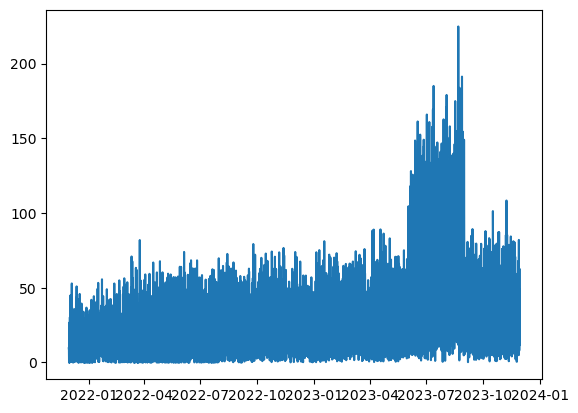

In [11]:
# plot the the consumption for the dataset
import matplotlib.pyplot as plt
plt.plot(final_df.index, final_df['Energy_Consumption'], label='Energy Consumption')

## Creating Cleaned Dataset
### Already Done, see 'TestDataset/CleanedColoradoData.csv'

In [5]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            print(f"Could not parse date: {date_str}")
            return pd.NaT

def clean_data():
    # Load the CSV file into a pandas dataframe
    df = pd.read_csv('ColoradoData.csv')

    # Strip extra whitespace from the column names
    df.columns = [col.strip() for col in df.columns]

    # Strip extra whitespace from the date columns
    df['Start_Date___Time'] = df['Start_Date___Time'].str.strip()
    df['End_Date___Time'] = df['End_Date___Time'].str.strip()

    # Now parse the datetime columns using the parse_date function
    df['Start_DateTime'] = df['Start_Date___Time'].apply(parse_date)
    df['End_DateTime'] = df['End_Date___Time'].apply(parse_date)

    # Convert duration columns to timedelta objects
    df['Total_Duration'] = pd.to_timedelta(df['Total_Duration__hh_mm_ss_'])
    df['Charging_Time'] = pd.to_timedelta(df['Charging_Time__hh_mm_ss_'])

    # Convert Energy consumption to a numeric type (handle errors)
    df['Energy_Consumption'] = pd.to_numeric(df['Energy__kWh_'], errors='coerce')

    # Remove the columns that are no longer needed
    df = df.drop(columns=['Start_Date___Time', 'End_Date___Time', 'Total_Duration__hh_mm_ss_',
                          'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'ObjectID', 'ObjectId2', 'Start_Time_Zone', 'End_Time_Zone', 
                          'Port_Type', 'GHG_Savings__kg_', 'Gasoline_Savings__gallons_', 'City'])

    # More data cleaning
    # Remove rows with negative energy consumption
    df = df[df['Energy_Consumption'] >= 0]

    # Remove rows with missing values
    df = df.dropna()

    # Remove rows with zero charging time
    df = df[df['Charging_Time'] > pd.Timedelta(0)]

    # Remove rows with zero energy consumption
    df = df[df['Energy_Consumption'] > 0]

    # Remove rows with zero total duration
    df = df[df['Total_Duration'] > pd.Timedelta(0)]

    # Remove rows with total duration less than charging time
    df = df[df['Total_Duration'] >= df['Charging_Time']]

    # Remove duplicates
    df = df.drop_duplicates(subset=['Start_DateTime', 'Charging_Time', 'Energy_Consumption'])

    # Sort the data by the Start_DateTime column
    df = df.sort_values(by=['Start_DateTime'], ascending=True)

    # Save the cleaned data to a new CSV file
    df.to_csv('TestDataset/CleanedColoradoData.csv')

    return df

df = clean_data()